# Clustering with DBSCAN

### DBSCAN and cluster evaluation using correlation

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
np.set_printoptions(precision=4, linewidth=125, suppress=True)

## Part 1. Generate test data

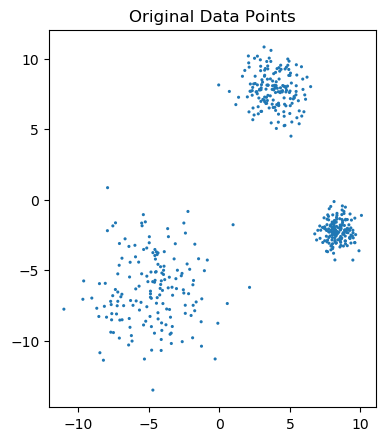

In [4]:
# Run this cell for 3 artificial clusters
N = 500

# Specify cluster centroids
c = 3 # random centroids
#c = [[6,7], [-7,0], [3,-5]] # specific centroids

# Configure the cluster standard deviations
#cl_stds = np.random.random(3)*1.5  # Different standard deviations
#cl_stds = 1.5 # all clusters have same SD
cl_stds = [2.5, 1.25, 0.75]

X, y_true = make_blobs(n_samples=N,
                        n_features=2,
                        centers=c,
                        center_box=(-10, 10),
                        cluster_std=cl_stds,
                        shuffle=False, random_state=None)

# Plot the dataset
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect=1.0)
ax.scatter(X[:, 0], X[:, 1], marker='.', s=20, edgecolor='None')
ax.set_title('Original Data Points')
#ax.set_xlim(-12, 12)
#ax.set_ylim(-12, 12)
plt.show()

## Part 2. Determine Eps and MinPts

For a given dataset, we'd like to determine good values for $Eps$ and $MinPts$.
One way to do this is to use the $k^{th}$-nearest neighbor (or $k$-dist) approach:

1. Compute the distance of the $k^{th}$-nearest neighbor
   from every point in the dataset for some value of $k$.

2. Sort he distances in increasing order.

3. Plot the distances on the $y$-axis.

We can expect to see a shart change ("elbow") in the resulting curve that
corresponds to a suitable value of $Eps$.

In [5]:
# Create a NearestNeighbors object, fit the data, then get the 4 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(X)
distances, indices = nbrs.kneighbors(X)

# Get the indexes of the array sorted by the 4th nearest neighbor
sorted_ix = distances[:,4].argsort()

# Extract the plot y values
px = list(range(len(distances)))
py = distances[sorted_ix,4]

The code below, for finding the knee point, is based on a Wikipedia article: "[Vector Projection](https://en.wikipedia.org/wiki/Vector_projection)"

In [6]:
N = len(py)

# Coordinates of all points on the curve
points_along_curve = np.column_stack([px, py])

# get the first point (origin)
first_point = points_along_curve[0]

# vector we're projecting onto
b = points_along_curve[-1] - points_along_curve[0]

# length of b
b_norm = np.linalg.norm(b)

b_hat = b / b_norm

# list of vectors (from first_point to every point along the curve)
a = points_along_curve - first_point

# scalar projection of a onto b:
a_1_norm = np.dot(a, b_hat)
a_1      = np.outer(b_hat, a_1_norm).T

# vector rejection:
a_2 = a - a_1

# Find the longest vector in a_2
# That is, the longest projection onto line b
best_ix = np.argmax(np.linalg.norm(a_2, axis=1))
best_eps = py[best_ix]

print("Knee: n={:d}, y={:.2f}".format(px[best_ix], best_eps))

Knee: n=451, y=1.01


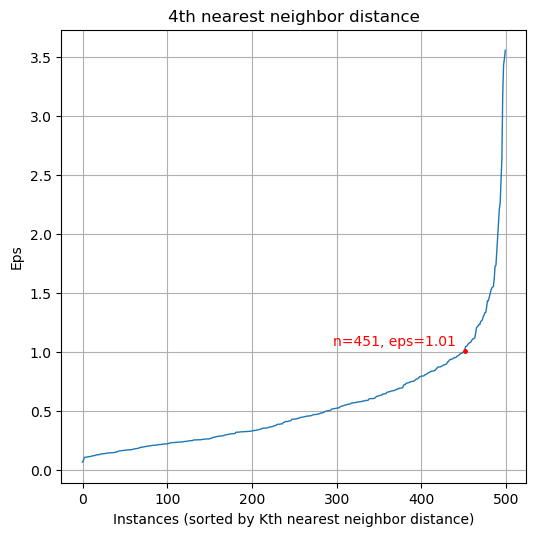

In [7]:
# Plot 'em
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.plot(px, py, linestyle='-', linewidth=1)
ax.plot(px[best_ix], py[best_ix], marker='.', c='red', markersize=5)
ax.text(px[best_ix]-10, py[best_ix]+0.05, s='n={}, eps={:.2f}'.format(best_ix, best_eps), color='red',
       horizontalAlignment='right')
ax.set_title('4th nearest neighbor distance')
ax.set_xlabel('Instances (sorted by Kth nearest neighbor distance)')
ax.set_ylabel('Eps')
ax.grid()

plt.show()

## Part 3. Cluster the points using DBSCAN

In [8]:
# Custom colormap
# The 0th color is gray, for noise points
mycmap = ListedColormap([
    '#000000', '#e6194b', '#3cb44b', '#ffe119', 
    '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
    '#f032e6', '#bcf60c', '#fabebe', '#008080', 
    '#e6beff', '#9a6324', '#fffac8', '#800000', 
    '#aaffc3', '#808000', '#ffd8b1', '#000075', 
    '#808080'
], name='mhb1', N=None)

We obtained 3 clusters.


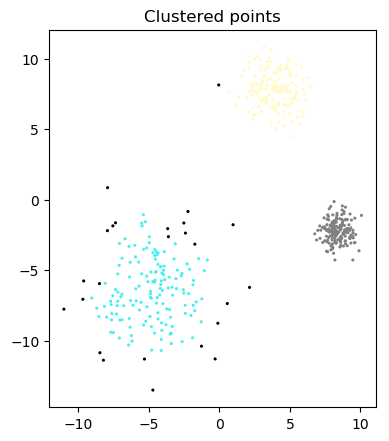

In [9]:
# Create DBSCAN object using our hyperparameters
dbest = DBSCAN(eps=best_eps, min_samples=4)

# Perform the clustering and get back the cluster labels
y = dbest.fit_predict(X)
print("We obtained {} clusters.".format(max(y)+1))

# Make pretty plot
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect=1)
ax.scatter(X[:, 0], X[:, 1], marker='.', c=y, s=20, edgecolor='None', cmap=mycmap)
ax.set_title('Clustered points')
plt.show()

## Part 4. Cluster Validity using Correlation

In [9]:
# Get indices of sorted class labels
y_order = y.argsort()

In [10]:
# Calculate incidence matrix
# 1 if point i and point j are in the same cluster, 0 otherwise
incd_mx = []
for i in y_order:
    row = []
    for j in y_order:
        if y[i] == y[j]:
            row.append(1)
        else:
            row.append(0)
    incd_mx.append(row)
incd_mx = np.array(incd_mx)

In [11]:
# Calculate distance matrix in y_order
dist_mx = []
for i in y_order:
    row = []
    for j in y_order:
        row.append(euclidean(X[i], X[j]))
    dist_mx.append(row)
dist_mx = np.array(dist_mx)

In [12]:
def myfunc(x):
    dmin = dist_mx.min()
    dmax = dist_mx.max()
    return(1-((x-dmin)/(dmax-dmin)))

In [13]:
sim_mx = myfunc(dist_mx)

In [14]:
corr, pvalue = pearsonr(np.array(sim_mx).reshape(-1,1), np.array(incd_mx).reshape(-1,1))
print(corr)
print(pvalue)

[0.8387]
[0.]


High correlation indicates that the points in the same cluster are "close" to one another.